# Project 5: Car crash data

## Modeling Notebook
This notebook is for modeling the car crash data.  It assumes that the cleaning and eda notebooks have been run.  

## Problem Statement:


In [1]:
#imports 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score

import random
random.seed (42)

In [2]:
#read data
crash = pd.read_csv('./data/crash_data_modified.csv')
crash.head()

,Crash Time of Day,Collision Type,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Driver At Fault,Driver Distracted By,Vehicle First Impact Location,Vehicle Second Impact Location,Vehicle Body Type,Vehicle Movement,Speed Limit,Parked Vehicle
0,Evening,SAME DIR REAR END,DRY,DAYLIGHT,STOP SIGN,No,No,No,SIX OCLOCK,SIX OCLOCK,PASSENGER CAR,STOPPED IN TRAFFIC LANE,25,No
1,Early Morning,SAME DIR REAR END,DRY,DAWN,TRAFFIC SIGNAL,No,No,No,SIX OCLOCK,SIX OCLOCK,PASSENGER CAR,STOPPED IN TRAFFIC LANE,40,No
2,Early Morning,SINGLE VEHICLE,DRY,DAYLIGHT,NO CONTROLS,No,No,No,ELEVEN OCLOCK,ELEVEN OCLOCK,POLICE VEHICLE/NON EMERGENCY,MOVING CONSTANT SPEED,35,No
3,Late Night,SINGLE VEHICLE,DRY,DARK LIGHTS ON,NO CONTROLS,No,No,No,TWELVE OCLOCK,TWELVE OCLOCK,POLICE VEHICLE/EMERGENCY,MOVING CONSTANT SPEED,35,No
4,Night,SAME DIR REAR END,DRY,DARK LIGHTS ON,NO CONTROLS,Yes,Yes,Yes,TWELVE OCLOCK,TWELVE OCLOCK,PASSENGER CAR,ACCELERATING,35,No


In [3]:
# original feature names
crash.columns

Index(['Crash Time of Day', 'Collision Type', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse', 'Driver At Fault',
       'Driver Distracted By', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Speed Limit', 'Parked Vehicle'],
      dtype='object')

## Basic look at occurences of features in data

In [4]:
# Driver substance abuse
crash['Driver Substance Abuse'].value_counts(normalize = True)

No     0.973233
Yes    0.026767
Name: Driver Substance Abuse, dtype: float64

In [5]:
# Driver distracted by
crash['Driver Distracted By'].value_counts(normalize = True)

No     0.784361
Yes    0.215639
Name: Driver Distracted By, dtype: float64

## Handling categorical variables (one-hot encoding)

In [6]:
columns_to_dummify = ['Crash Time of Day', 'Collision Type', 'Surface Condition', 'Light',
       'Traffic Control', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Parked Vehicle']

df = pd.get_dummies(crash,columns=columns_to_dummify, drop_first=True)

In [7]:
df = pd.get_dummies(crash, columns = columns_to_dummify)

In [8]:
df.drop (columns = ['Traffic Control_NO CONTROLS', 
                    'Surface Condition_DRY', 
                    'Crash Time of Day_Noon', 
                    'Light_DAYLIGHT', 
                    'Vehicle Movement_MOVING CONSTANT SPEED'], 
         inplace = True)

In [9]:
df['Driver At Fault'] = df['Driver At Fault'].map({'No':0, 'Yes':1})
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].map({'No':0, 'Yes':1})
df['Driver Distracted By'] = df['Driver Distracted By'].map({'No':0, 'Yes':1})

In [10]:
df.head()

,Driver Substance Abuse,Driver At Fault,Driver Distracted By,Speed Limit,Crash Time of Day_Early Morning,Crash Time of Day_Evening,Crash Time of Day_Late Night,Crash Time of Day_Morning,Crash Time of Day_Night,Collision Type_ANGLE MEETS LEFT HEAD ON,...,Vehicle Movement_PARKING,Vehicle Movement_PASSING,Vehicle Movement_RIGHT TURN ON RED,Vehicle Movement_SKIDDING,Vehicle Movement_SLOWING OR STOPPING,Vehicle Movement_STARTING FROM LANE,Vehicle Movement_STARTING FROM PARKED,Vehicle Movement_STOPPED IN TRAFFIC LANE,Parked Vehicle_No,Parked Vehicle_Yes
0,0,0,0,25,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,40,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,35,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,35,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,35,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Setting up our features and target

In [11]:
# get X and y; train,test,split the data
X = df.drop(columns = 'Driver At Fault')
y = df['Driver At Fault']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13424)

## Modeling

### Null Model

In [12]:
df['Driver At Fault'].value_counts(normalize = True)

0    0.556386
1    0.443614
Name: Driver At Fault, dtype: float64

For this data set 55.6% of the crashes were listed as the driver not at fault.  This means that if we assign the driver as never at fault we would have a baseline accuracy of 55.6%.  

### Simple Logistic Regression Model

In [13]:
# logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [14]:
print('Logistic Regression metrics\n')
print('           training           testing')
print('Accuracy: ',logreg.score(X_train,y_train),logreg.score(X_test,y_test))
print('f1:       ',f1_score(y_train,logreg.predict(X_train)),f1_score(y_test,logreg.predict(X_test)))

Logistic Regression metrics

           training           testing
Accuracy:  0.8908028640830647 0.8935511526004953
f1:        0.8757676468463261 0.8793522267206477


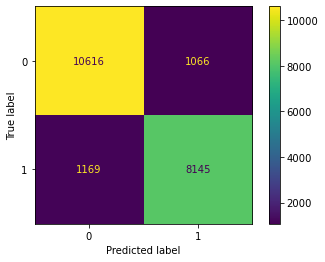

In [15]:
plot_confusion_matrix(logreg,X_test,y_test);

For the logistic regression model, the confusion matrix is fairly balanced with only slightly more Type II errors than Type I errors.  It has a fairly high accuracy and fairly high f1 score.  

In [16]:
# dataframe from the fit coefficients
logreg_coef_dict = {entry[0]:entry[1] for entry in list(zip(X.columns, logreg.coef_[0]))}
logreg_coef_df = pd.DataFrame(logreg_coef_dict.values(), index = logreg_coef_dict.keys())
logreg_coef_df.columns = ['logreg coef']

### Decision Tree Modeling

In [17]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [18]:
print('Decision Tree metrics\n')
print('           training           testing')
print('Accuracy: ', tree.score(X_train,y_train),tree.score(X_test,y_test))
print('f1:       ',f1_score(y_train,tree.predict(X_train)),f1_score(y_test,tree.predict(X_test)))

Decision Tree metrics

           training           testing
Accuracy:  0.8749900773175417 0.8760240045722995
f1:        0.8523975555805495 0.8538707685398305


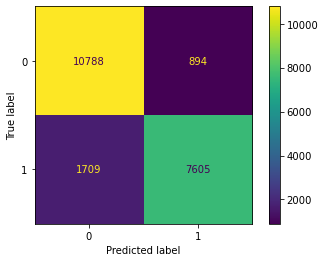

In [19]:
plot_confusion_matrix(tree,X_test,y_test);

For the decision tree model, the confusion matrix is unbalanced with vastly more Type II errors than Type I errors.  It has a fairly high accuracy and fairly high f1 score though.  

In [20]:
tree_imp_dict = {entry[0]:entry[1] for entry in list(zip(X.columns,tree.feature_importances_))}
tree_imp_df = pd.DataFrame(tree_imp_dict.values(), index = tree_imp_dict.keys())
tree_imp_df.columns = ['tree importance']
tree_imp_df.sort_values(by = ['tree importance'], ascending= False).head(20)

,tree importance
Driver Distracted By,0.503336
Vehicle First Impact Location_SIX OCLOCK,0.180337
Collision Type_SAME DIR REAR END,0.113551
Collision Type_SINGLE VEHICLE,0.083383
Vehicle Movement_MAKING LEFT TURN,0.048773
Vehicle Second Impact Location_TWELVE OCLOCK,0.035818
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.011977
Vehicle Movement_BACKING,0.009246
Vehicle Second Impact Location_ONE OCLOCK,0.004326
Vehicle Body Type_POLICE VEHICLE/NON EMERGENCY,0.003806


The feature importances for the decision tree model are different than for the logistic regression model.  

The tree model also shows driver distraction is the key indicator of driver responsibility in a crash.  

This also has driver substance abuse of lower importance than the in the logistic regression model.  This is very interesting and we should investigate further.  

### Random Forest

In [21]:
forest = RandomForestClassifier(max_depth = 14)
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=14)

In [22]:
print('Random Forest metrics\n')
print('           training           testing')
print('Accuracy:',forest.score(X_train,y_train),forest.score(X_test,y_test))
print('f1:      ',f1_score(y_train,forest.predict(X_train)),f1_score(y_test,forest.predict(X_test)))

Random Forest metrics

           training           testing
Accuracy: 0.9070284344388525 0.8998856925128595
f1:       0.8918559556786703 0.8840723582616368


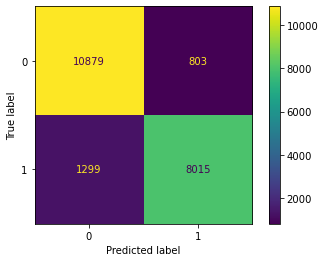

In [23]:
plot_confusion_matrix(forest,X_test,y_test);

For the random forest model, the confusion matrix is skews slightly with more Type II errors than Type I errors.  It has a high accuracy and high f1 score.  

In [24]:
forest_imp_dict = {entry[0]:entry[1] for entry in list(zip(X.columns,forest.feature_importances_))}
forest_imp_df = pd.DataFrame(forest_imp_dict.values(), index = forest_imp_dict.keys())
forest_imp_df.columns = ['forest importance']
forest_imp_df.sort_values(by = ['forest importance'], ascending= False).head(20)

,forest importance
Driver Distracted By,0.222565
Vehicle First Impact Location_SIX OCLOCK,0.103027
Collision Type_SAME DIR REAR END,0.085152
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.081685
Vehicle Second Impact Location_SIX OCLOCK,0.078998
Vehicle Second Impact Location_TWELVE OCLOCK,0.060643
Vehicle First Impact Location_TWELVE OCLOCK,0.060262
Collision Type_SINGLE VEHICLE,0.048783
Vehicle Movement_MAKING LEFT TURN,0.040964
Collision Type_STRAIGHT MOVEMENT ANGLE,0.026391


The random forest shows similar feature importances to the tree and has about 5 points higher accuracy.  



## Model metrics

In [25]:
## model comparison
models = [logreg,tree,forest]
model_metrics = [(model.score(X_train,y_train), 
                  model.score(X_test,y_test),
                  f1_score(y_train,model.predict(X_train)),
                  f1_score(y_test,model.predict(X_test))
                 ) for model in models]
metrics_df = pd.DataFrame(model_metrics, 
                          columns = ['training_accuracy', 
                                     'testing_accuracy',
                                     'training_f1',
                                     'testing_f1'
                                    ], 
                          index = ['logreg','tree','forest'])
null_acc = df['Driver At Fault'].value_counts(normalize = True)[0]
metrics_df.loc[metrics_df.shape[0]] = [null_acc, null_acc, 'undefined', 'undefined']

metrics_df.index = ['logreg','tree','forest', 'null']

metrics_df.head()

,training_accuracy,testing_accuracy,training_f1,testing_f1
logreg,0.890803,0.893551,0.875768,0.879352
tree,0.874990,0.876024,0.852398,0.853871
forest,0.907028,0.899886,0.891856,0.884072
null,0.556386,0.556386,undefined,undefined


Comparing the models, the logistic regression and random forest both do quite well.  The forest has a slightly better testing accuracy and f1 score but shows slightly more variance.  All the models outperform the null model in which we assign all cases to be 0 (driver not at fault).  

The random forest shows slightly better scores and provides information about feature importance.  However, it does not indicate if the importance is telling us it is positively correlated or negatively correlated with fault in an accident.  For this reason, we will examine the logistic regression coefficients in addition to the random forest feature importance.  

## Model Output

We will look at the most important individual features in determining fault as well as the most important within a given category.   

### Most important overall features

In [26]:
# making dataframes for coefficients and importances
results = pd.merge(left = forest_imp_df,right = logreg_coef_df, left_index=True, right_index=True)

important_features = forest_imp_df.sort_values('forest importance', ascending = False).head(20)

#looking at high absolute value coef
high_coefs = logreg_coef_df.sort_values('logreg coef', ascending = False).head(10)
low_coefs = logreg_coef_df.sort_values('logreg coef', ascending = True).head(10)

important_coefs = pd.concat([high_coefs,low_coefs])
important_coefs.sort_values('logreg coef', ascending = False, inplace = True);

# looking at absolute value of coefficient as logistic regression importance
important_coefs['importance'] = important_coefs['logreg coef'].apply(abs)
important_coefs['sign'] = important_coefs['logreg coef'].apply(lambda x: '+' if x>=0 else '-')

In [27]:
forest_imp_df.sort_values('forest importance', ascending = False).head(10)

,forest importance
Driver Distracted By,0.222565
Vehicle First Impact Location_SIX OCLOCK,0.103027
Collision Type_SAME DIR REAR END,0.085152
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.081685
Vehicle Second Impact Location_SIX OCLOCK,0.078998
Vehicle Second Impact Location_TWELVE OCLOCK,0.060643
Vehicle First Impact Location_TWELVE OCLOCK,0.060262
Collision Type_SINGLE VEHICLE,0.048783
Vehicle Movement_MAKING LEFT TURN,0.040964
Collision Type_STRAIGHT MOVEMENT ANGLE,0.026391


In [28]:
logreg_coef_df.sort_values('logreg coef', ascending = False).head(10)

,logreg coef
Vehicle Movement_BACKING,6.108053
Driver Distracted By,3.955130
Vehicle Movement_CHANGING LANES,3.692386
Vehicle Movement_MAKING U TURN,3.512027
Vehicle Movement_PASSING,3.131283
Driver Substance Abuse,3.071846
Vehicle Movement_ENTERING TRAFFIC LANE,3.054638
Vehicle Movement_RIGHT TURN ON RED,2.521771
Vehicle Movement_MAKING LEFT TURN,2.480264
Collision Type_SAME DIR REAR END,2.177790


In [29]:
logreg_coef_df.sort_values('logreg coef', ascending = True).head(10)

,logreg coef
Vehicle First Impact Location_SIX OCLOCK,-3.046964
Vehicle Movement_STOPPED IN TRAFFIC LANE,-2.181723
Vehicle Second Impact Location_SIX OCLOCK,-1.350375
Collision Type_SAME DIR BOTH LEFT TURN,-1.302236
Collision Type_ANGLE MEETS LEFT HEAD ON,-1.049114
Parked Vehicle_Yes,-0.995147
Vehicle Movement_PARKED,-0.995147
Vehicle Body Type_POLICE VEHICLE/NON EMERGENCY,-0.988309
Collision Type_HEAD ON LEFT TURN,-0.798397
Vehicle First Impact Location_ROOF TOP,-0.753846


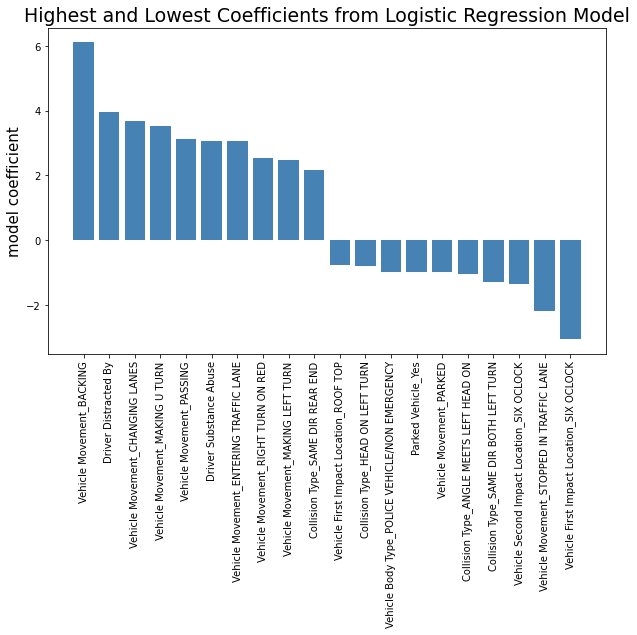

In [30]:
plt.figure(figsize=(10,6))
plt.bar(x = important_coefs.index, 
        height = important_coefs['logreg coef'], 
        color = 'steelblue');
plt.title('Highest and Lowest Coefficients from Logistic Regression Model', size = 19);
plt.xticks(rotation = 90);
plt.ylabel('model coefficient', size = 15)
#plt.xlabel('model feature', size = 15)
plt.savefig('./images/high_low_coef.png', format='png')

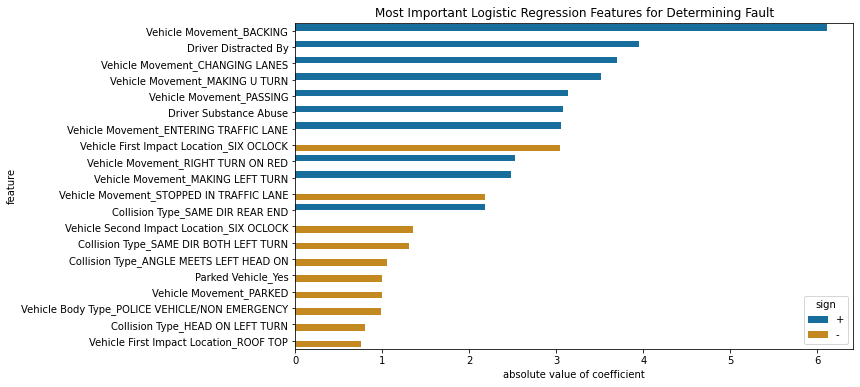

In [31]:
plt.figure(figsize = (10,6))
absolute_values = important_coefs.reset_index()
sns.barplot(data=absolute_values.head(20).sort_values('importance', ascending = False),
            y = 'index',
            x = 'importance', 
            hue = 'sign',
            palette = 'colorblind')

plt.title('Most Important Logistic Regression Features for Determining Fault');
plt.xlabel('absolute value of coefficient');
plt.ylabel('feature')
plt.savefig('./images/logreg_importance.png',format='png')

### Most important features within a category
Isolating original features and examining which values contribute most to our undestanding of fault in the accident.  We use the logistic regression coefficients for categorical variables which tell us the increase/decrease compared to a default conditions shown below.  


|Feature| Default condition|
|---|---|
|time of day| noon|
|lighting | daylight|
|surface condition | dry|
|traffic control| no controls|
|vehicle movement| moving constant speed|

In [32]:
#function for plotting specific subsets
def plot_category(catname):
    plt.figure(figsize = (10,6))
    cat_df = logreg_coef_df.copy()
    cat_df = cat_df[cat_df.index.str.contains(catname)]

    cat_df['sign'] = cat_df['logreg coef'].apply(lambda x: '+' if x>=0 else '-')
    cat_df['imp'] = cat_df['logreg coef'].apply(abs)

    cat_df = cat_df.reset_index()
    data = cat_df[cat_df['index'].str.contains(catname)].sort_values('imp', ascending = False)
    sns.barplot(data=data,
            y = 'index',
            x = 'logreg coef', 
            hue = 'sign',
            palette = 'colorblind')
#plt.xticks(rotation = 90);
    plt.title(f'Most Important {catname} Features for Determining Fault');
    plt.xlabel('feature');
    plt.savefig(f'./images/logreg_importance_{catname}.png',format='png')

#### Vehicle movement

Default vehicle movement is `MOVING CONSTANT SPEED`.

The most important feature is `STOPPED IN TRAFFIC LANE` which, holding all else equal, is more strongly negatively correlated with driver fault than teh default of `MOVING CONSTANT SPEED`.  Similarly, `SLOWING OR STOPPING` and `PARKED` show lower chance of driver fault in an accident than traveling at a constant speed.  

Comparing coefficients we see that driver fault is least likely when `STOPPED IN TRAFFIC LANE` and most likely when `BACKING`.  


In [33]:
forest_imp_df[forest_imp_df.index.str.contains('Movement')].sort_values('forest importance', ascending = False)

,forest importance
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.081685
Vehicle Movement_MAKING LEFT TURN,0.040964
Vehicle Movement_CHANGING LANES,0.019002
Vehicle Movement_SLOWING OR STOPPING,0.013603
Vehicle Movement_MAKING RIGHT TURN,0.008142
Vehicle Movement_BACKING,0.007881
Vehicle Movement_ACCELERATING,0.007714
Vehicle Movement_MAKING U TURN,0.002774
Vehicle Movement_PASSING,0.002146
Vehicle Movement_ENTERING TRAFFIC LANE,0.002132


In [34]:
logreg_coef_df[logreg_coef_df.index.str.contains('Movement')].sort_values('logreg coef', ascending = False)

,logreg coef
Vehicle Movement_BACKING,6.108053
Vehicle Movement_CHANGING LANES,3.692386
Vehicle Movement_MAKING U TURN,3.512027
Vehicle Movement_PASSING,3.131283
Vehicle Movement_ENTERING TRAFFIC LANE,3.054638
Vehicle Movement_RIGHT TURN ON RED,2.521771
Vehicle Movement_MAKING LEFT TURN,2.480264
Vehicle Movement_SKIDDING,2.089081
Vehicle Movement_LEAVING TRAFFIC LANE,2.035851
Vehicle Movement_MAKING RIGHT TURN,2.026153


Vehicle Movement
MOVING CONSTANT SPEED      33753
SLOWING OR STOPPING        14919
STOPPED IN TRAFFIC LANE    12254
MAKING LEFT TURN            8409
ACCELERATING                4353
STARTING FROM LANE          2569
MAKING RIGHT TURN           2352
CHANGING LANES              2030
MAKING U TURN                496
PARKED                       485
BACKING                      444
STARTING FROM PARKED         417
ENTERING TRAFFIC LANE        389
SKIDDING                     338
PASSING                      304
NEGOTIATING A CURVE          179
RIGHT TURN ON RED            111
PARKING                      102
LEAVING TRAFFIC LANE          72
DRIVERLESS MOVING VEH.         7
dtype: int64

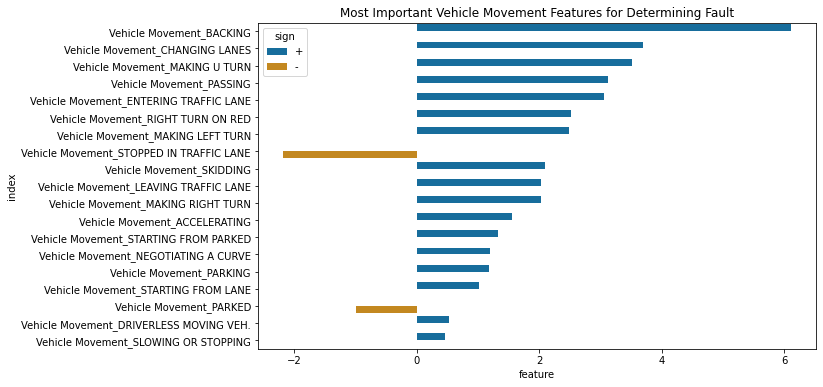

In [35]:
plot_category('Vehicle Movement')
crash.value_counts('Vehicle Movement')

#### Substance Abuse

As expected, substance abuse is a highly important feature with strong, positive correlation with fault in the accident. 

In [36]:
forest_imp_df[forest_imp_df.index.str.contains('Substance Abuse')].sort_values('forest importance', ascending = False)

,forest importance
Driver Substance Abuse,0.016226


In [37]:
logreg_coef_df[logreg_coef_df.index.str.contains('Substance Abuse')].sort_values('logreg coef', ascending = False)

,logreg coef
Driver Substance Abuse,3.071846


#### Speed Limit

Speed limit was left as a continuous variable.  

Holding all else equal, higher speed limits are correlated with less driver fault.  This is likely effect of the prevalence of speeding in areas with low speed limits.  People may be less cautious on low-speed-limit roads than they would otherwise be and thus be more prone to errors that result in crashes.  

In [38]:
forest_imp_df[forest_imp_df.index.str.contains('Speed')].sort_values('forest importance', ascending = False)

,forest importance
Speed Limit,0.007949


In [39]:
logreg_coef_df[logreg_coef_df.index.str.contains('Speed')].sort_values('logreg coef', ascending = False)

,logreg coef
Speed Limit,-0.013624


#### Time of day

Default time of day is `Noon`.

None of the time of day categories show high importance in determining fault with all options grouped fairly close in importance.  

Crashes in`Evening` and `Night` were less likely to be driver-caused than crashes as `Noon`.  Crashes `Late Night`, `Morning`, and `Early Morning` were more likely to be driver caused than crashes at `Noon`.    



In [40]:
#forest
forest_imp_df[forest_imp_df.index.str.contains('Time')].sort_values('forest importance', ascending = False)

,forest importance
Crash Time of Day_Evening,0.001362
Crash Time of Day_Morning,0.001119
Crash Time of Day_Early Morning,0.000937
Crash Time of Day_Night,0.000916
Crash Time of Day_Late Night,0.000805


In [41]:
logreg_coef_df[logreg_coef_df.index.str.contains('Time')].sort_values('logreg coef', ascending = True)

,logreg coef
Crash Time of Day_Evening,-0.083880
Crash Time of Day_Night,-0.049740
Crash Time of Day_Late Night,0.003007
Crash Time of Day_Morning,0.054543
Crash Time of Day_Early Morning,0.131780


Crash Time of Day
Evening          23814
Noon             21199
Morning          18532
Night             8853
Early Morning     8442
Late Night        3143
dtype: int64

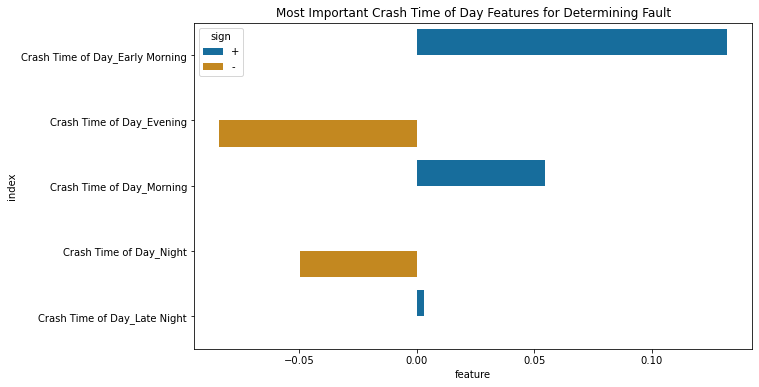

In [42]:
plot_category('Crash Time of Day')
crash.value_counts('Crash Time of Day')

#### Surface Conditions

Default surface condition is `DRY`.

Compared to dry conditions, snow, ice or water tend to indicate driver fault whereas mud, dirt, gravel tends to indicated driver not at fault.  Drivers are much more likely to be at fault in wet conditions.

In [43]:
forest_imp_df[forest_imp_df.index.str.contains('Surface')].sort_values('forest importance', ascending = False)

,forest importance
Surface Condition_WET,1.849929e-03
Surface Condition_ICE,4.706845e-04
Surface Condition_SNOW,3.619001e-04
"Surface Condition_MUD, DIRT, GRAVEL",8.274622e-05
Surface Condition_SLUSH,5.826445e-05
Surface Condition_WATER(STANDING/MOVING),5.384357e-05
Surface Condition_OIL,1.365929e-06
Surface Condition_SAND,1.055101e-07


In [44]:
logreg_coef_df[logreg_coef_df.index.str.contains('Surface')].sort_values('logreg coef', ascending = False)

,logreg coef
Surface Condition_SNOW,0.856885
Surface Condition_ICE,0.620794
Surface Condition_WET,0.260551
Surface Condition_WATER(STANDING/MOVING),0.141917
Surface Condition_SAND,0.028466
Surface Condition_SLUSH,-0.002184
Surface Condition_OIL,-0.023942
"Surface Condition_MUD, DIRT, GRAVEL",-0.708325


Surface Condition
DRY                       66139
WET                       16448
ICE                         661
SNOW                        557
SLUSH                       116
MUD, DIRT, GRAVEL            26
WATER(STANDING/MOVING)       26
OIL                           9
SAND                          1
dtype: int64

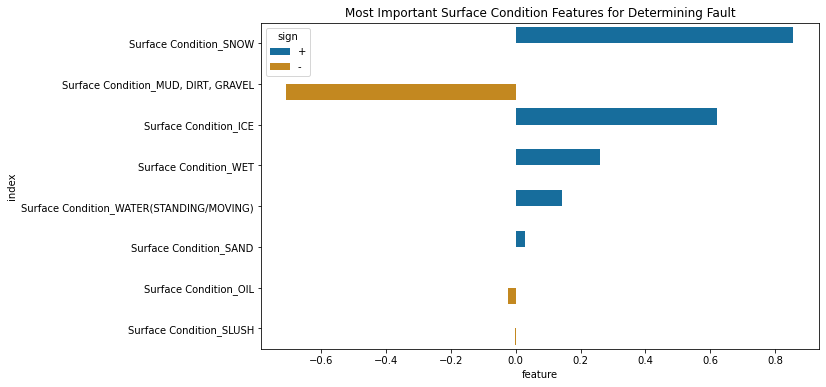

In [45]:
plot_category('Surface Condition')
crash.value_counts('Surface Condition')

#### Traffic Control

Default for traffic control is `NO CONTROLS`.  

Compared to no controls, `WARNING SIGN`, `RAILWAY CROSSING DEVICE`, `FLASHING TRAFFIC SIGNAL`, `YIELD SIGN`, and `SCHOOL ZONE SIGN DEVICE` are all mild indicators of driver fault.  They are, however, very low on the list of important features.  

In [46]:
forest_imp_df[forest_imp_df.index.str.contains('Traffic Control')].sort_values('forest importance', ascending = False)

,forest importance
Traffic Control_TRAFFIC SIGNAL,5.369113e-03
Traffic Control_STOP SIGN,4.035134e-03
Traffic Control_YIELD SIGN,4.328447e-04
Traffic Control_FLASHING TRAFFIC SIGNAL,3.793168e-04
Traffic Control_PERSON,6.955143e-05
Traffic Control_WARNING SIGN,2.126178e-05
Traffic Control_RAILWAY CROSSING DEVICE,1.294328e-05
Traffic Control_SCHOOL ZONE SIGN DEVICE,9.502342e-07


In [47]:
logreg_coef_df[logreg_coef_df.index.str.contains('Control')].sort_values('logreg coef', ascending = False)

,logreg coef
Traffic Control_WARNING SIGN,0.566574
Traffic Control_RAILWAY CROSSING DEVICE,0.388825
Traffic Control_FLASHING TRAFFIC SIGNAL,0.276344
Traffic Control_YIELD SIGN,0.116923
Traffic Control_SCHOOL ZONE SIGN DEVICE,0.090265
Traffic Control_STOP SIGN,-0.092641
Traffic Control_TRAFFIC SIGNAL,-0.093000
Traffic Control_PERSON,-0.393253


Traffic Control
NO CONTROLS                41639
TRAFFIC SIGNAL             32914
STOP SIGN                   6955
FLASHING TRAFFIC SIGNAL     1167
YIELD SIGN                  1078
PERSON                       117
WARNING SIGN                  92
RAILWAY CROSSING DEVICE       12
SCHOOL ZONE SIGN DEVICE        9
dtype: int64

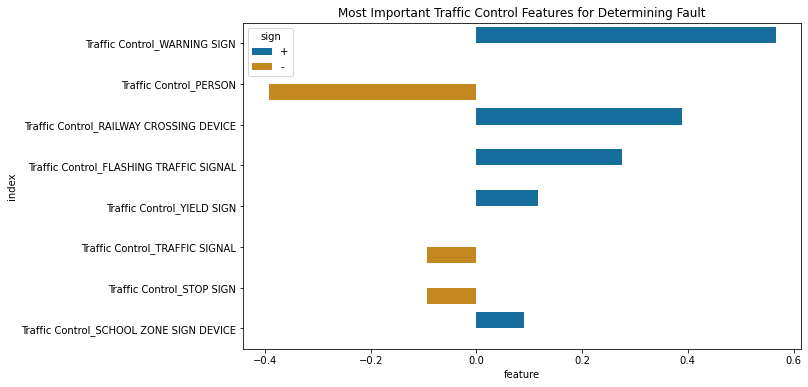

In [48]:
plot_category('Traffic Control')
crash.value_counts('Traffic Control')

#### Light Conditions

Default for light is `DAYLIGHT`.  

Compared to daylight, all other light situations are negatively correlated with driver fault.  That is, the driver is less likely to be responsible in dark conditions than in full daylight conditions.  

In [49]:
forest_imp_df[forest_imp_df.index.str.contains('Light')].sort_values('forest importance', ascending = False)

,forest importance
Light_DARK LIGHTS ON,0.001357
Light_DARK NO LIGHTS,0.000703
Light_DAWN,0.000438
Light_DUSK,0.000404
Light_DARK -- UNKNOWN LIGHTING,0.000240


In [50]:
logreg_coef_df[logreg_coef_df.index.str.contains('Light')].sort_values('logreg coef', ascending = False)

,logreg coef
Light_DUSK,-0.072055
Light_DARK LIGHTS ON,-0.149331
Light_DAWN,-0.218778
Light_DARK NO LIGHTS,-0.258096
Light_DARK -- UNKNOWN LIGHTING,-0.411316


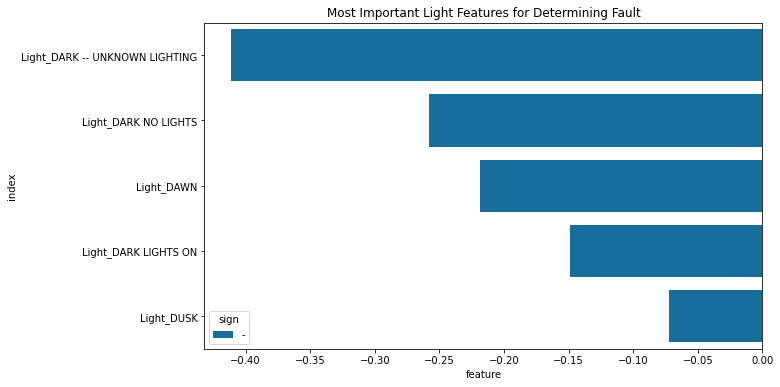

In [51]:
plot_category('Light')

## Summary

We built a logistic regression model that is able to determine driver fault in a crash based on basic crash facts.  The model showed 89% accuracy for both training and testing with 87.5% F1 score.  We saw very mild improvement in using a random forest model but lost the interpretability in terms of sign of correlation with driver fault.  

Overall the features most associated with driver fault were vehicle movement, driver distraction, driver substance abuse.  The movement most associated with accidents was backing up.  Changing langes, passing and u-turns were also strongly correlated with driver fault.  With the exception of u-turns these are very basic maneuvers that drivers do everyday.  

Speed limit was negatively correlated with driver fault in accidents, indicating that driver-caused accidents are more likely in lower speed environments.  

Traffic controls were associated with fault when the signs were related to warnings, railway crossings, flashing lights and school-zones. This is a particuarly troubling finding given that it means people are disregarding traffic controls.  

Daylight conditions were actually the most correlated with driver fault in crashes.  They are also highly prevalent in the crash data and thus should be a focus of mitigation strategies.  

